# Russian Layout Optimization with Bigrams

In [1]:
import pandas as pd
pd.options.display.max_rows = 100
from math import floor
from collections import defaultdict

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
    - [Visualizing bigrams in QGIS](#qgis)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

# Initialization and Code <a name="init">

In [2]:
# leter categories. V = vowel, C = consonant.
# nb: So-called "soft sign" Ь and "hard sign" Ъ are ancient vowels, and labelled as such.
LT = {'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'}

# these keys MUST be in any layout, otherwise the code throws an exception and halts
BASE_KEYS = set('ё-!?%*():;йцукенгшщзхъфывапролджэячсмитьбю.,⌴¶')


class Corpus:
    def __init__(self, bigrams):
        self.bigrams = bigrams
        
    def from_string(raw_text):
        # we take text and encode it, replacing space, linebreak and tab with displayable surrogates.
        # (layouts are encoded with spaces and linebreaks as separators, so this way we won't confuse them)
        text = raw_text.lower().replace(' ', '⌴').replace('\n', '¶').replace('\t', '→')

        nums = defaultdict(int)
        for i in range(2, len(text)):
            nums[text[i-2:i]] += 1

        bigrams = pd.DataFrame(nums.items(), columns=['bigram', 'num'])
        bigrams['l1'] = bigrams.bigram.str[:1]
        bigrams['l2'] = bigrams.bigram.str[1:]
        for i in (1, 2):
            bigrams[f't{i}'] = bigrams[f'l{i}'].map(lambda l: 'v' if l.lower() in LT['v'] else ('c' if l.lower() in LT['c'] else '-'))       
        bigrams['freq'] = bigrams.num / bigrams.num.sum()
        return Corpus(bigrams)
        
    # simple function that reads the corpus and creates a bigram table.
    def from_path(path):
        """Reads file from path and calculates bigrams frequencies."""
        with open(path) as f:
            return Corpus.from_string(f.read())
    
    def display_outerness(self, filter_expr, left_hand=False):
        """Provide a `filter_expr` to filter the bigrams of the corpus,
        and this function will display a table and a plot with
        where a letter is more often in digrams in the subset.

        E.g. English S more often comes first among consonants.
        So it will be on the right (towards right hand pinky)."""
        d2 = self.bigrams[self.bigrams.eval(filter_expr)]
        t2 = d2.groupby('l1').agg({'freq': 'sum'}).join(d2.groupby('l2').agg({'freq': 'sum'}), how='outer', lsuffix='_out', rsuffix='_in')
        t2.fillna(0, inplace=True)
        t2['outer'] = - t2.freq_in + t2.freq_out
        t2['frequency'] = t2.freq_in + t2.freq_out
        t2['outerness'] = t2.outer / t2.frequency
        t2 *= 10000
        title = 'left hand: pinky <-> index' if left_hand else 'right hand: index <-> pinky'
        ax = t2[['frequency', 'outerness']].plot.scatter(x='outerness', y='frequency', title=title)
        for i, r in t2.iterrows():
            ax.annotate(i, (r.outerness + .1, r.frequency + .1))

        return t2.sort_values('outerness') # to readable numbers

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [3]:
CORP = Corpus.from_path('sampletexts.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

,freq_out,freq_in,outer,frequency,outerness
э,0.000000,0.734130,-0.734130,0.734130,-10000.000000
ё,0.000000,0.063837,-0.063837,0.063837,-10000.000000
ю,0.526658,28.184209,-27.657551,28.710868,-9633.129516
я,3.016317,42.707216,-39.690899,45.723533,-8680.628272
е,17.108421,75.503677,-58.395256,92.612098,-6305.359297
и,35.876615,13.661202,22.215413,49.537817,4484.536082
о,30.562152,8.586129,21.976023,39.148281,5613.534448
у,13.357975,3.495097,9.862877,16.853072,5852.272727
а,46.266151,3.096114,43.170037,49.362264,8745.554478
ъ,1.899162,0.000000,1.899162,1.899162,10000.000000


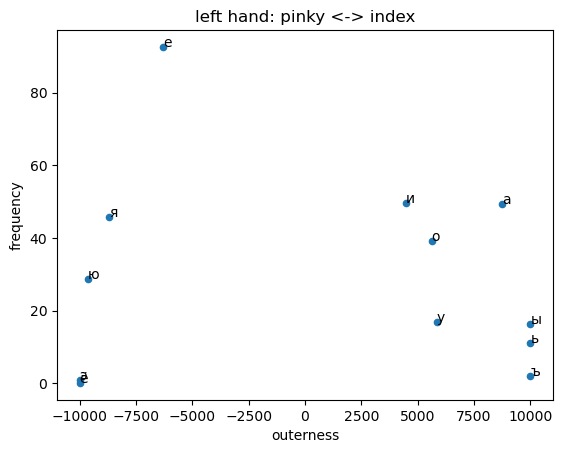

In [4]:
CORP.display_outerness("t1 == 'v' & t2 == 'v'", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

,freq_out,freq_in,outer,frequency,outerness
ц,1.739569,9.830959,-8.091390,11.570528,-6993.103448
щ,0.718171,3.191870,-2.473699,3.910040,-6326.530612
н,63.502247,164.333410,-100.831163,227.835657,-4425.609414
р,66.438767,149.922118,-83.483351,216.360886,-3858.523272
л,44.015883,94.112277,-50.096394,138.128160,-3626.805315
к,53.942597,96.905163,-42.962566,150.847761,-2848.074482
т,88.015806,148.437899,-60.422093,236.453705,-2555.345572
м,19.933226,20.188576,-0.255350,40.121802,-63.643596
в,68.593279,60.677442,7.915837,129.270722,612.345679
д,54.181988,37.584265,16.597722,91.766253,1808.695652


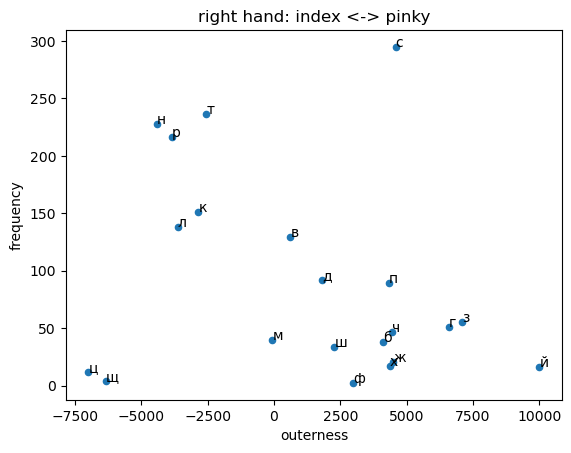

In [5]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [6]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# The Code with The Scoring Rules <a name="scoring-code">

Here we define what fingers press what keys. 0 = left pinky, 9 = right pinky, others in between as you may imagine, left to right.

Spaces & line breaks in beginning of FINGERS/POS_PENALTY are insignificant, but spaces in actual lines with numbers are. These positions must be matched by keyboard descriptions. 

In [7]:
d = {'a': {'id': 1, 'val': 2}, 'b': {'id': 3, 'val': 4}}
pd.DataFrame.from_dict(d, orient='index')

,id,val
a,1,2
b,3,4


In [8]:
STANDARD_FINGERS = '''
001233 6678999
001233 66789999
 01233 6678999
 01233 66789
4
''' 

STANDARD_PENALTIES = '''
432111 1111123
210012 21001123
 00001 1000012
 00002 20001
0
'''

In [9]:
def parse_layer(text):
    "Parses text of a layer of layout, fingers or position penalties."
    keys_map = {}
    for ir, row in enumerate(text.lstrip().rstrip().split('\n')):
        for ic, f in enumerate(row):
            if f != ' ' and f != '∅':
                keys_map[(ir, ic)] = f
    return keys_map


def get_finger_props(finger):
    return {
        'finger': finger,  # finger unique ID. (left pinky = 0, left ring = 1, ... right pinky = 9)
        'ftype': floor(abs(4.5 - finger)),  # number in its hand (thumb = 0, pinky = 4)
        'hand': (0 if finger < 4.5 else 1), # hand numebre. Left = 0, right = 1
        'penalty': 0, # position penalty (ie. monogram). From POS_PENALTY
    }

KEYCAP_LAYER_SHIFTS = {
    0: (.3, .3),
    1: (.1, .6),
    2: (.5, 0),
    3: (.5, .6),
    -1: (.25, .25)
}

class Keyboard:
    """Keeps fingers and penalties map of a model or a fingers positioning scheme."""
    def __init__(self, name, fingers, penalties, key_display=None, extra_keys=None):
        """Creates the instance. Fingers and penalties are strings with lines as rows,
        and line positions of chars as columns. They must match exactly.
        
        Parameters
        ----------
        - name, str: just the name
        - fingers, str: string, where line is row, char pos is column, and the number in there (0..9)
            is the finger. 0 = left pinky, 1 = left ring, .. 9 = right pinky.
            Penalties map and layouts must reproduce these positions.
        - penalties, str: integer penalties in the same positions.
        - key_display, function: a callback that processes a key to be rendered.
            Like adding stagger, depending on row/column.
            Input params: (x: float, y: float, width: float, height: float, keycap: list[str])
            Output: a tuple with the same items.
            This callback won't process `extra_keys`.
        - extra_keys, list: a list of tuples of extra keys to render in the image:
            (x: float, y: float, width: float, height: float, keycap: str).
            Keycap is a single string.

        """
        self.name = name
        self.extra_keys = extra_keys
        self.key_display = key_display
        self.keymap = {}
        for (ir, ic), f in parse_layer(fingers).items():
            props = get_finger_props(int(f))
            self.keymap[(ir, ic)] = props

        for (ir, ic), p in parse_layer(penalties).items():
            if (ir, ic) not in self.keymap:
                raise ValueError("Penalties map doesn't match fingers map!")
            
            self.keymap[(ir, ic)]['penalty'] = int(p)
    
    def display(self, key_caps=None, color=None):
        """
        Displays the keyboard. Empty or with `key_caps` from a layout.
        
        Parameters
        ----------
        - key_caps: {(row: int, colunm: int): [(cap: str, layer: int)]}.
        - color, str | dict: either string 'fingers'|'penalty', or a dict: {(row, column): color str}.
        
        """
        keys = pd.DataFrame([{'row': ir, 'column': ic}
                            for (ir, ic), v in self.keymap.items()])
        
        width = keys.column.max() + 1 - keys.column.min()
        height = keys.row.max() + 1 - keys.row.min()
        
        fig, ax = plt.subplots(1, 1, figsize=(width, height))
        ax.set_axis_off()
        #print('xlim', min_x - .5, max_x + 1)
        
        font = {'family': 'dejavu sans',
            'color':  '#000',
            'size': 14,
            'linespacing': 1.7,
            'ha': 'center'
        }
        
        show_fingers = color in ('finger', 'fingers')
        show_penalties = color in ('penalty', 'penalties')
        if show_penalties:
            key_caps = {(ir, ic): [(k['penalty'], 0)] for (ir, ic), k in self.keymap.items()}
        
        max_penalty = None if not show_penalties else max(v['penalty'] for v in self.keymap.values())
        
        max_x = max_y = min_x = min_y = 0
        for (ir, ic), k in self.keymap.items():
            w = h = 1
            x = ic
            y = ir
            
            caps = key_caps.get((ir, ic), []) if key_caps else []
            if self.key_display:
                x, y, w, h, caps = self.key_display(x, y, w, h, caps)
                
            y *= -1
            min_x = min(x, min_x)
            min_y = min(y, min_y)
            max_x = max(x + w, max_x)
            max_y = max(y + h, max_y)

            if show_fingers:
                key_color = plt.cm.Set3((k['finger'] + (k['finger'] % 2) * 10) / 20)
            elif show_penalties:
                key_color = plt.cm.plasma(k['penalty'] / max_penalty)
            else:
                key_color = (.8, .8, .8, 1)
        

            # we draw the rectangle making a outer margin of 0.2.
            # We just shift the box right-bottom, and make it narrower and lower by 0.4,
            # so that all keys are still referred by key size (1 unit = 20mm),
            # and this is done consistently everywhere.
            ax.add_patch(Rectangle((x + .2, y + .2), w - .4, h - .4,
               color=key_color, ec=key_color, 
               capstyle='round', linewidth=15, linestyle='-', joinstyle='round'))
            
            if key_caps is None:
                continue
            
            for (cap, layer) in caps:
                if cap == '⌴': continue
                if layer not in KEYCAP_LAYER_SHIFTS:
                    raise ValueError(f'incorrect layer {layer} in record {cap} in keymap')

                dx, dy = KEYCAP_LAYER_SHIFTS[layer]
                
                # same shifting for text
                text_y = y + dy + .1
                text_x = x + dx + .2
                
                font_size = 14 if layer == 0 else 10
            
                plt.text(text_x, text_y, cap, fontdict={
                    **font, 'color':  '#000', 'size': font_size}) # if key.get('c', 0) else '#444444'})
        
        # making narrower by 0.4 and shifting by 0.2 in both dimensions.
        for (x, y, w, h, cap) in self.extra_keys:
            ax.add_patch(Rectangle((x + .2, - y + .2), w - .4, h - .4,
               color='#888', ec='#888',
               capstyle='round', linewidth=15, linestyle='-', joinstyle='round'))
            
            # same shift for text
            plt.text(x + .2 + w / 2 - .2, - y + .1 + h / 2 - .2, cap, fontdict={
                    **font, 'color':  '#fff'}) # if key.get('c', 0) else '#444444'}) 

        ax.set_xlim(min_x - .5, max_x + .5)
        ax.set_ylim(min_y - .5, max_y + .5)

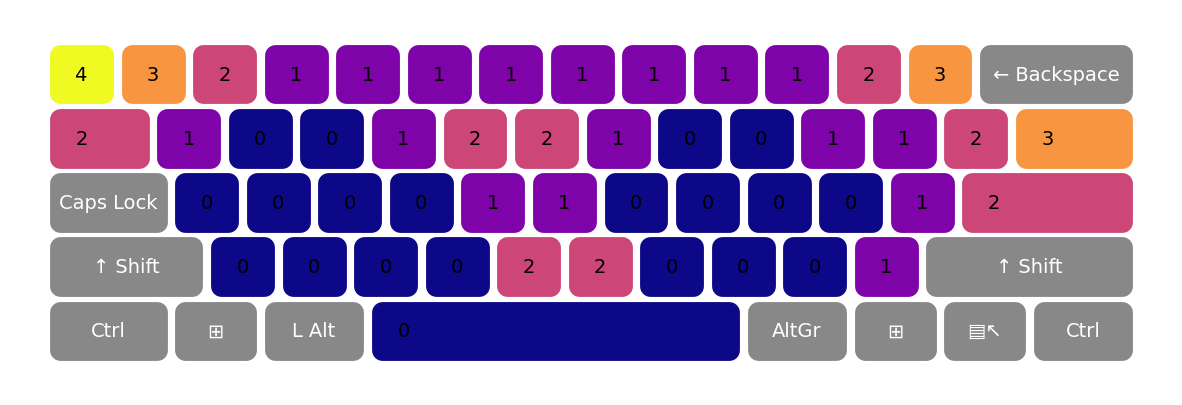

In [10]:
ROW_STAGGER = { 0: 0, 1: .5, 2: .75, 3: 1.25, 4: 1.75 }
                
def std_display(x, y, w, h, caps):
    if x > 6:
        x -= 1


    if x == 0 and y == 1: # '→':
        x -= .5
        w = 1.5
    
    if y == 4: # space bar
        w = 5.25
        x = 2.75
        
    if y == 1 and x == 13: # the / key above the enter
        w = 1.75
    
    if y == 2 and x == 12: # enter
        w = 2.5
        
    if y not in ROW_STAGGER: 
        raise ValueError(f"Row must be 0..=4, got {y} instead.")

    x += ROW_STAGGER[y]

    return x, y, w, h, caps
        
STD_EXTRA_KEYS = [
    (13, 0, 2.25, 1, '← Backspace'),
    
    (0, 2, 1.75, 1, 'Caps Lock'),
    
    (0, 3, 2.25, 1, '↑ Shift'),
    (12.25, 3, 3, 1, '↑ Shift'),

    (0, 4, 1.75, 1, 'Ctrl'),
    (1.75, 4, 1.25, 1, '⊞'),
    (3, 4, 1.5, 1, 'L Alt'),
    (9.75, 4, 1.5, 1, 'AltGr'),
    (11.25, 4, 1.25, 1, '⊞'),
    (12.5, 4, 1.25, 1, '▤↖'),
    (13.75, 4, 1.5, 1, 'Ctrl'),
]
STANDARD_KBD = Keyboard('standard staggered', STANDARD_FINGERS, STANDARD_PENALTIES, std_display, STD_EXTRA_KEYS)

STANDARD_KBD.display(None, 'penalties')

In [11]:
ERGODOX = Keyboard('ergodox',

# note: in the middle columns, there are 2 tall keys, not 3, but I'm not sure how to represent it here,
# so for now, it's set like there are 3.
'''
0012333 6667899
0012333 6667899
0012333 6667899
0012333 6667899
00123     67899
    444 555
''', # ehm... in reality, I press the outermost keys on the top row with the ring fingers, not pinky, so...
# maybe it's better to write the real usage here...

'''
4321234 4321234
1000023 3200001
1000013 3100001
1000023 3200001
21111     11112
    000 000
''')

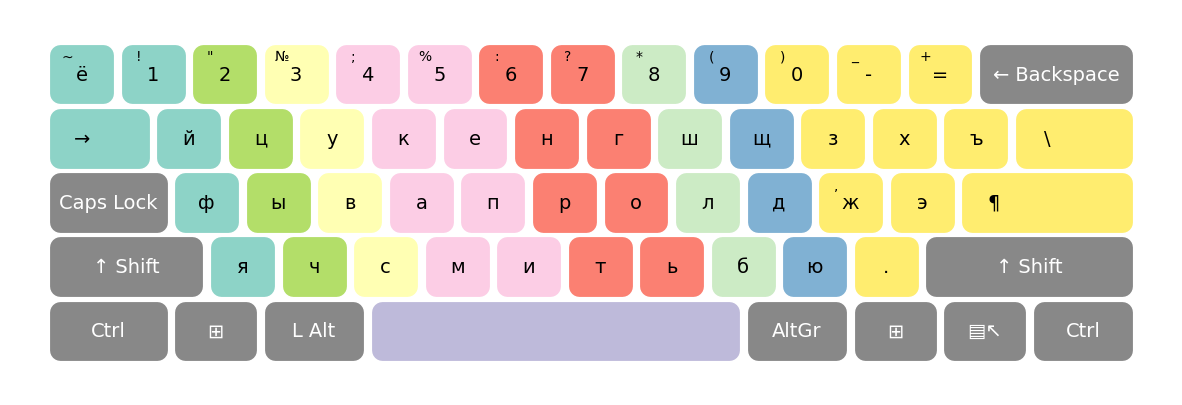

In [12]:
class Layout:
    """Keeps positions of keys on a particular keyboard."""
    def __init__(self, name, layout_config, debug=False):
        """Initialize the layout. `layout_config` must be either text, or 2-tuple (layout text, Keyboard instance)."""

        if isinstance(layout_config, tuple):
            if len(layout_config) != 2:
                raise ValueError(f'Layout must be either a string, or a 2-tuple (layout, keyboard). Got tuple of {len(layout_config)} instead.')
            layout_text, keyboard = layout_config
        else:
            layout_text, keyboard = (layout_config, STANDARD_KBD)

        layers = layout_text.lstrip().rstrip().split('\n\n')
        maps = [parse_layer(l) for l in layers]
        if debug: print('layout', layers)
        keys = ''.join(k for m in maps for k in m.values())
        if debug: print('layout', keys)
        key_counts = defaultdict(int)
        for k in keys:
            key_counts[k] += 1

        for k in set(keys):
            if key_counts[k] > 1 and k not in ('⌴', '¶', '→'):
                print(f'key "{k}" repeated: {key_counts[k]}')

        missing = BASE_KEYS - set(keys)

        if missing:
            raise ValueError(f"Missing keys: {''.join(missing)}, present keys: {''.join(keys)}")

        # making a dict: {letter: (layer, row, column, <finger id>, <finger num in hand>, hand, <pos penalty>)}
        # the last 4 items come from get_finger_props(...) calls
        # make any changes here => change the pd.DataFrame call below
        data = {}
        
        for il, layer in enumerate(maps):
            for (ir, ic), k in layer.items():
                if debug: print(il, ir, ic, k, (ir, ic) in keyboard.keymap)
                if k != '∅' and (ir, ic) in keyboard.keymap:
                    data[k] = {'layer': il, 'row': ir, 'column': ic,
                               'key_count': key_counts,
                               **keyboard.keymap[(ir, ic)]}

        self.name = name
        self.keymap = pd.DataFrame.from_dict(data, orient='index')
        self.keyboard = keyboard
        self.original_text = layout_text


    def get_monogram_cost(self, l2):
        """Simply looks up keymap and gets pos_penalty field. Lowercases the letters."""
        
        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # here we should but don't penalize Shift/AltGr pressing
            else:
                if l2 in BASE_KEYS or l2.lower() in BASE_KEYS:
                    print(l2)
                    print(self.keymap.index)
                    raise ValueError(f'base key \'{l2}\' is not in the layout! (may be caused by unquoted backslash)')
                return 0

        return self.keymap.loc[l2].penalty


    # THE MAIN PENALTIES RULES
    # Here we assign costs and also put a text name for the reason why bigram got it,
    # to quickly see WTF is happening
    def get_bigram_cost(self, bigram):
        l1, l2 = bigram

        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # lowercase (= no penalties for shifts)
            else:
                return 0, 'L2 not in kbd'
        k2 = self.keymap.loc[l2]

        if l1 not in self.keymap.index:
            if l1.lower() in self.keymap.index:
                l1 = l1.lower() # lowercase of l1.
            else:
                return 0, 'L1 not in kbd'
        k1 = self.keymap.loc[l1]

        rules = (
            (k1.ftype == 0 or k2.ftype == 0, 0, 'space bar'),
            (k1.hand != k2.hand, 0, 'altern hands'),
            (l1 == l2, 0, 'same key'),

            (abs(k2.row - k1.row) >= 2 and k1.ftype == k2.ftype, 8, 'same finger over row'),

            (k1.ftype == k2.ftype, 6, 'same finger adj row'),

            (abs(k2.row - k1.row) >= 2 and abs(k1.finger - k2.finger) < 3, 6, 'adj finger over row'),

            (k1.ftype == 1 and k2.ftype == 4, 2, 'index -> pinky'),

            (k1.ftype > k2.ftype and abs(k2.row - k1.row) >= 2, 3, 'in, over 1 row'),
            (k1.ftype > k2.ftype + 1 and abs(k2.row - k1.row) <= 1, 0, 'in, over 1 finger'),
            (k1.ftype == k2.ftype + 1 and k2.row <= k1.row, 1, 'in, adj finger, same or adj row'),

            (k1.ftype > k2.ftype and k2.row > k1.row, 0, 'in, lower row'),

            (k1.ftype + 1 == k2.ftype, 6, 'out, next finger'),
            (k2.ftype > k1.ftype, 4, 'out, over one finger'),
        )

        for cond, penalty, reason in rules:
            if cond:
                return penalty, reason

        return 4, 'none'

    def display(self, color='fingers'):        
        """
        Shows the layout with the keyboard.
        
        Parameters
        ----------
        - color: None|'fingers'|'penalty'
            if 'finger', will color by fingers, if 'penalty' will colorscale those.
        """
        keycaps = defaultdict(list)
        for k, r in self.keymap.iterrows():
            keycaps[(r['row'], r['column'])].append((k, r['layer']))
        
        self.keyboard.display(keycaps, color)

l = Layout('йцуцкен', r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''')
l.display()

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [13]:
layouts = {
    # standard Russian layout
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщъ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅!"№;% ;\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # https://habr.com/ru/articles/717912/
('''
∅123456 7890-=
→щцклбй фъыяэ
 чзвнтд сиаое¶
 жхпрмг шёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅
 ∅∅∅∅,∅ .∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅
∅

''',
Keyboard("leonov's remapping", '''
0001233 667899
0001233 66789
 001233 667899
 001233 66789
4
''',
'''
4321111 111234
3210002 20000
 100001 100001
 100002 20000
0
''', std_display, STD_EXTRA_KEYS
)),
    'optozorax': # https://optozorax.github.io/p/my-keyboard-layout/#russkii-iazyk
    # author never mentions parens in his keyboard definition. I just tossed them wherever there was place.
    ('''
    
+;.:=@∅ ∅*!?#/∅
-йцуеф∅ ∅щгтнз∅
"кмвап∅ ,ролджэ
'ячсиы∅ ∅шьбюхё
∅∅∅∅∅∅∅ ∅∅∅\∅∅∅
    ∅∅¶ .⌴∅

(75319^ №02468)
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
&∅∅∅∅∅∅ $∅∅∅∅∅∅
|∅∅∅∅∅∅ ∅∅ъ∅∅∅∅
∅∅∅∅∅     ∅%∅∅∅
    ∅∅∅ ∅∅∅
''',
ERGODOX),
    
    'ergodox':  # standard Russian on Ergodox (has troubles with right end of the upper row)
(''' 
ё123456 7890\ъ∅
-йцуке∅ ∅нгшщзх
=фывап∅ ∅ролджэ
∅ячсми∅ ∅тьбю.∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅,∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
    
    # my layouts
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

∅12345 67890-=
→ъыфхэ цнмвчзшж
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№;% :∅?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [14]:
layouts2 = {}
for k, definition in layouts.items():
    layouts2[k] = Layout(k, definition)

key """ repeated: 2
key "?" repeated: 2
key ";" repeated: 2
key "." repeated: 2
key ";" repeated: 2
key """ repeated: 3
key ":" repeated: 2
key "." repeated: 2


In [15]:
class Result:
    # Gets the cost for input KBD text, bigrams & fingers maps
    def __init__(self, corpus, layout):
        bigram_df = corpus.bigrams.copy()

        # taking the text of keyboard layout and encode it into keymap a dataframe
        bigram_df['price_l2'] = bigram_df.l2.apply(layout.get_monogram_cost)

        # calculate bigrams cost
        bigram_df[['price_di', 'category']] = bigram_df.bigram.apply(lambda d: pd.Series(layout.get_bigram_cost(d)))
        bigram_df['price'] = bigram_df.price_l2 + bigram_df.price_di
        bigram_df['cost'] = bigram_df.price * bigram_df.num
        bigram_df['finger'] = bigram_df['l2'].map(layout.keymap.finger)
        bigram_df['column'] = bigram_df['l2'].map(layout.keymap.column)
        bigram_df['row'] = bigram_df['l2'].map(layout.keymap.row)
        self.bigrams = bigram_df
        self.corpus = corpus # it's not copied here, just a pointer
        self.layout = layout # also not copied
        self.score = bigram_df.cost.sum() / bigram_df.num.sum()

    def compare(self, other):
        x = self.bigrams[['bigram', 'num', 'category', 'price', 'cost']].merge(
            other.bigrams[['bigram', 'category', 'price', 'cost']],
            on='bigram', suffixes=['_old', '_new'])
        
        x['delta'] = x['cost_new'] - x['cost_old']
        return x[x.delta != 0].sort_values('delta', ascending=False)

def compare(results_dict, key1, key2):
    return results_dict[key1].compare(results_dict[key2])

In [16]:
results = {}

for k, lyt in layouts2.items():
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.0019
layout usphonetic: 1.8928
layout rusdvorak: 0.9842
layout диктор: 0.7812
layout зубачёв: 0.7317
layout скоропис: 0.7779
layout ант: 0.9234
layout ugnvs: 1.3668
layout леонов: 0.6947
layout optozorax: 1.1708
layout ergodox: 1.8748
layout тест1: 1.7523
layout тест2: 1.5991
layout тест3: 1.2224
layout тест4: 1.0169
layout тест5: 0.8836
layout тест6: 0.9061
layout тест7: 0.9102
layout тест8: 0.8978
layout тест9: 0.9072
layout тест10: 0.7321
layout тест11: 0.7731
layout тест12: 0.7737
layout тест13: 0.7477
layout тест14: 0.7185
layout тест15: 0.6462
layout тест16: 0.6422
layout тест17: 0.6135
layout тест18: 0.6321
layout тест19: 0.6391
layout тест20: 0.6458
layout тест21: 0.6121
layout тест22: 0.6121
layout тест23: 0.5898
layout тест24: 0.5468
layout тест25: 0.5952
layout ино1: 0.5296
layout тест26: 0.549
layout тест27: 0.5359
layout ино2: 0.4407
layout тест28: 0.5391


# Final Standings <a name="standings">

In [17]:
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('optozorax', 'ErgoDox Moonlander, alien'),
    ('ergodox', 'Stardand Russian on Ergodox'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('тест17', ''),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест26', 'Currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
df = pd.DataFrame(
    [(k, results[k].score.round(3), d) for k, d in chosen_kbd]
, columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
print(df.to_markdown(index=False))

# how well I am against Leonov's layout (the best of eariler authors' layouts)
1 - results['тест27'].score / results['леонов'].score

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.441 | Alien #2, many counterparts on AltGr   |
| ино1       |   0.53  | Alien #1, rare letters on AltGr        |
| тест26     |   0.549 | Currently in use on my laptop          |
| тест17     |   0.613 |                                        |
| леонов     |   0.695 | Leonov                                 |
| зубачёв    |   0.732 | Zubachov                               |
| тест10     |   0.732 | First optimized after hand testing     |
| скоропис   |   0.778 | Skoropis                               |
| диктор     |   0.781 | Dictor                                 |
| тест9      |   0.907 | First hand-tested                      |
| ант        |   0.923 | ANT                                    |
| rusdvorak  |   0.984 | Dvorak translit                        |
| optozorax  |   1.171 | ErgoDox Moonlander, alien              |
| ugnvs   

0.2286476950077646

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
0000123 6789999
001233  66789999
 01233  66789999
 01233  667899
4
''', '''
4321111 1111234
210012  21001123
 00001  10000123
 00002  200001
0
'''))
```

In [18]:
'''
→эыфх:  цнмвчзжш
 аоией  ,ртксд¶
 ьуюяё  щлбпг
'''
lyt = Layout('тест28', r'''

ъ12345 67890-=
→щфыхё цнмвчзж
 аоией шртксд¶
 ьуюяэ ,лбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅
∅
''')


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 4), '')

тест28 : 0.5928 


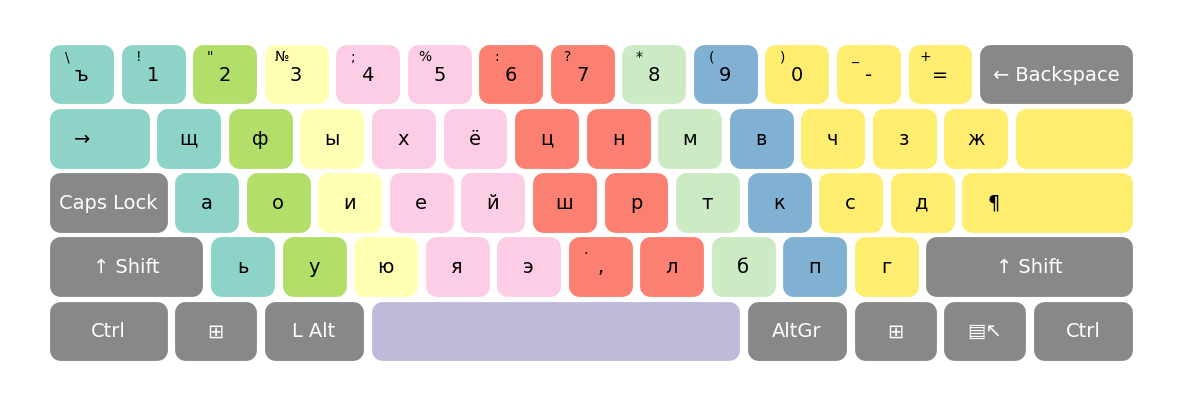

In [19]:
lyt.display()

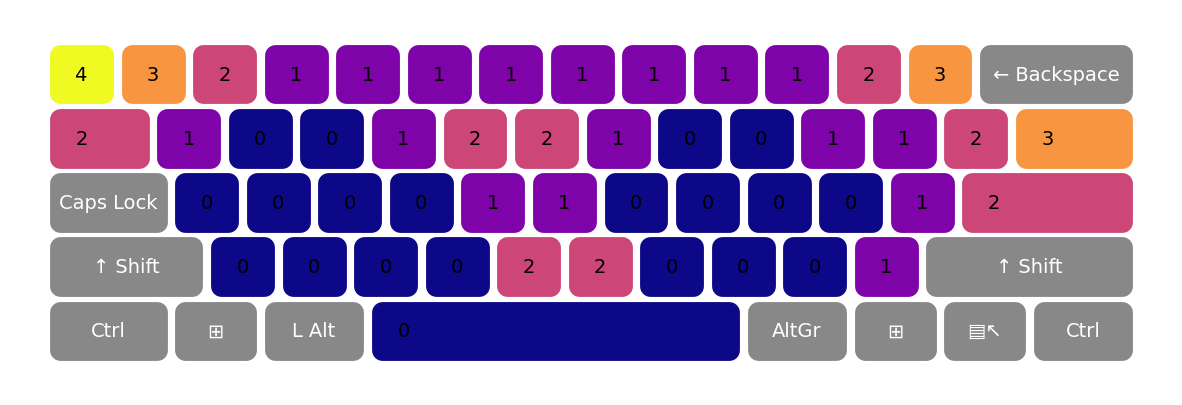

In [20]:
lyt.display('penalties')

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

## Losses

In [21]:
compare(results, 'тест26', 'тест28') #.head(20)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
253,"м,",752,"in, lower row",1,752,adj finger over row,8,6016,5264
207,..,3334,same key,1,3334,same key,2,6668,3334
123,м.,410,"in, lower row",1,410,adj finger over row,8,3280,2870
335,"в,",229,"in, over 1 finger",1,229,adj finger over row,8,1832,1603
284,"а,",1470,altern hands,1,1470,altern hands,2,2940,1470
...,...,...,...,...,...,...,...,...,...
222,аш,471,altern hands,2,942,altern hands,1,471,-471
445,ыш,480,altern hands,2,960,altern hands,1,480,-480
43,ош,515,altern hands,2,1030,altern hands,1,515,-515
388,⌴ш,980,space bar,2,1960,space bar,1,980,-980


## Gains

In [22]:
compare(results, 'тест27', 'тест28').tail(20)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
621,я:,22,same finger over row,10,220,altern hands,1,22,-198
927,кш,27,"out, next finger",9,243,"in, over 1 finger",1,27,-216
851,у:,36,adj finger over row,8,288,altern hands,1,36,-252
1007,рщ,41,same finger adj row,8,328,altern hands,1,41,-287
902,дш,39,same finger adj row,9,351,"in, over 1 finger",1,39,-312
835,е:,45,same finger adj row,8,360,altern hands,1,45,-315
694,щн,44,same finger over row,9,396,altern hands,1,44,-352
405,сш,52,same finger adj row,9,468,"in, over 1 finger",1,52,-416
442,чш,53,same finger adj row,9,477,"in, over 1 finger",1,53,-424
530,ьш,241,altern hands,3,723,altern hands,1,241,-482


You can save comparison table to CSV:

In [23]:
compare(results, 'леонов', 'тест28').to_csv('leonov-test28.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [24]:
results['тест28'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

,bigram,num,l1,l2,t1,t2,freq,price_l2,price_di,category,price,cost,finger,column,row
74,.¶,2327,.,¶,-,-,0.003714,2,2,index -> pinky,4,9308,9.0,13.0,2.0
124,вс,1446,в,с,c,c,0.002308,0,6,"out, next finger",6,8676,9.0,11.0,2.0
109,⌴н,8502,⌴,н,-,c,0.013569,1,0,space bar,1,8502,6.0,8.0,1.0
132,⌴-,3685,⌴,-,-,-,0.005881,2,0,space bar,2,7370,9.0,12.0,0.0
327,ей,1000,е,й,v,c,0.001596,1,6,same finger adj row,7,7000,3.0,5.0,2.0
207,..,3334,.,.,-,-,0.005321,2,0,same key,2,6668,6.0,7.0,3.0
253,"м,",752,м,",",c,-,0.001200,2,6,adj finger over row,8,6016,6.0,7.0,3.0
271,рн,812,р,н,c,c,0.001296,1,6,same finger adj row,7,5684,6.0,8.0,1.0
184,тв,882,т,в,c,c,0.001408,0,6,"out, next finger",6,5292,8.0,10.0,1.0
334,хо,987,х,о,c,v,0.001575,0,4,"out, over one finger",4,3948,1.0,2.0,2.0


## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [25]:
key = 'тест28' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [26]:
layouts2['тест28'].keymap
# or 
# results['тест28'][1]

,layer,row,column,key_count,finger,ftype,hand,penalty
1,0,0,1,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",0,4,0,3
2,0,0,2,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",1,3,0,2
3,0,0,3,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",2,2,0,1
4,0,0,4,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",3,1,0,1
5,0,0,5,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",3,1,0,1
6,0,0,7,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",6,1,1,1
7,0,0,8,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",6,1,1,1
8,0,0,9,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",7,2,1,1
9,0,0,10,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",8,3,1,1
0,0,0,11,"{'1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': ...",9,4,1,1


# Where do letters want to move? <a name="letters-move">
    
TODO

## Visualizing Frequencies in QGIS <a name="qgis">

In [27]:
letters = results['тест28'].bigrams[['column', 'row', 'l2', 'num']].groupby(['column', 'row', 'l2']).agg({'num': 'sum'}).reset_index()
letters['WKT'] = 'POINT(' + letters['column'].astype(str) + ' ' + (4 - letters['row']).astype(str) + ')'
letters.to_csv('letters-freq.csv')

# Is Ergodox better? <a name="is-ergodox-better">

Let's compare the standard layout on standard keyboard with it on Ergodox. This of course is not a good representation, but may shed light on problems with some keys having to move to awkward places.

The first test here showed that I got finger numbers wrong in `ERGODOX`, that's why this is also helpful.

In [28]:
compare(results, 'йцукен', 'ergodox').head(20)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
520,"х,",356,same finger adj row,6,2136,same finger over row,8,2848,712
153,а:,61,altern hands,1,61,same finger over row,12,732,671
612,й-,132,altern hands,2,264,same finger adj row,7,924,660
786,-с,85,altern hands,0,0,adj finger over row,6,510,510
637,и:,43,altern hands,1,43,same finger over row,12,516,473
835,е:,45,altern hands,1,45,same finger adj row,10,450,405
540,м:,31,altern hands,1,31,same finger over row,12,372,341
767,о?,98,same finger over row,9,882,same finger over row,12,1176,294
435,е?,97,altern hands,1,97,altern hands,4,388,291
696,у-,93,altern hands,2,186,"out, over one finger",5,465,279


# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

In [29]:
results['тест28'].bigrams.pivot_table('num', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000
row,,,,,,,,,,,,,
0.000000,119,907,675,16,73,7,596,839,18,94,72,5155,0
1.000000,0,1758,847,10443,4617,9,2009,32479,15545,21841,7197,8767,4499
2.000000,0,41409,52847,34254,39950,6213,4706,23281,28025,19514,25700,13713,3544
3.000000,0,8229,15328,2812,9282,1155,24769,26267,8176,14092,9649,0,0
4.000000,94769,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
results['йцукен'].bigrams.pivot_table('num', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000
row,,,,,,,,,,,,,
0.000000,9,907,675,16,73,7,596,839,18,94,72,5155,0
1.000000,0,6213,2009,15328,19514,39950,32479,9649,4706,1758,8767,4617,119
2.000000,0,847,10443,21841,41409,14092,23281,52847,26267,13713,17872,1155,3544
3.000000,0,9282,7197,25700,15545,34254,28025,8229,8176,2812,11396,0,0
4.000000,94769,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
results['скоропис'].bigrams.pivot_table('num', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000
row,,,,,,,,,,,,,,
0.000000,0,81,23,135,837,833,11,5152,18,32,73,65,0,0
1.000000,0,2009,8229,9282,13436,11981,8767,21841,19514,13713,7197,4706,1758,661
2.000000,0,15328,34254,39950,52847,41409,26267,32479,28025,25700,23281,6213,3544,0
3.000000,0,847,1155,4617,10443,2812,8176,15545,14092,9649,4499,0,0,0
4.000000,94769,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
results['ант'].bigrams.pivot_table('num', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000
row,,,,,,,,,,,,,,
0.000000,15,854,839,11,16,81,7,5154,10,12,18,66,726,0
1.000000,0,9649,14092,23281,13713,15545,10443,34254,9282,15328,4617,2009,4499,7197
2.000000,0,21841,32479,25700,28025,26267,8348,52847,39950,41409,19514,8767,3544,0
3.000000,0,1758,6213,4706,8176,13436,11981,2812,1155,9,847,0,0,0
4.000000,94769,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
results['тест9'].bigrams.pivot_table('cost', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000
row,,,,,,,,,,,,,,
0.000000,8,5015,2107,17,257,7,2528,2485,18,100,298,12908,0,0
1.000000,0,19,0,1358,10430,11464,36778,55673,2299,16123,11021,10907,22012,15315
2.000000,0,5232,4117,11252,2239,55868,33268,5718,16844,3559,15986,25065,22510,0
3.000000,0,4332,324,879,5318,19472,51337,4505,4117,84,57257,0,0,0
4.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
results['леонов'].bigrams.pivot_table('cost', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000
row,,,,,,,,,,,,,
0.000000,0,3731,1902,31,189,7,1536,3649,18,100,412,21309,0
1.000000,0,4242,4103,15950,17817,3045,12426,2177,90,1374,22478,400,0
2.000000,0,9555,2364,10905,25681,17119,18156,58758,15701,11347,8494,24190,8944
3.000000,0,5963,746,2658,36069,2373,20199,14750,12,12144,3462,8740,0
4.000000,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
results['тест28'].bigrams.pivot_table('cost', 'row', 'column', aggfunc='sum', fill_value=0)\
.style.format(precision=0).background_gradient(cmap='viridis', axis=None)

column,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000
row,,,,,,,,,,,,,
0.000000,478,5719,2347,17,294,7,2104,1940,18,100,196,12000,0
1.000000,0,7594,1937,7,11629,42,5422,44247,2979,11135,10339,11723,10140
2.000000,0,3618,7323,1740,1856,13245,6045,3120,12338,15750,19520,25031,13020
3.000000,0,144,2348,2370,934,2446,70964,7247,4003,3222,12743,0,0
4.000000,0,0,0,0,0,0,0,0,0,0,0,0,0
